In [6]:
from SimulationDataset import *

import matplotlib.pyplot as mpl
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

Examine the spatial distribution of detector hits, if they cross the full detector from the origin crystal Lu decay

In [7]:
def ReadBackground( crystalData ):
    
    z = []
    phi = []
    energyNearSide = []
    energyFarSide = []
    for dataset in crystalData:
        for i in range( dataset.size() ):
            event = dataset.SampleOneEvent()
            for hit in event:
                phiVal = hit[5]
            
                # Ensure it's not a decay in the same crystal
                if math.fabs( phiVal ) > math.pi / 4.0:
                    z.append( hit[6] )
                    energyFarSide.append( hit[2] )
                
                    # Rotate to opposite side centred
                    phiVal -= math.pi
                    if phiVal < -math.pi:
                        phiVal += 2.0 * math.pi
                    phi.append( phiVal )
                    
                else:
                    energyNearSide.append( hit[2] )
                    
    return energyNearSide, energyFarSide, z, phi

def Make2DHistForAttenuation( energy, z, phi ):

    print( "Detector-crossing hits: ", len(z) )
    hist = mpl.hist2d( z, phi, bins=[11,22], range=[[-550,550], [-math.pi,math.pi]], weights=energy )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Axial coordinate [mm]" )
    mpl.ylabel( "Phi coordinate [radians]")
    mpl.show()

Re-using previous simulation
862623.0 events loaded (1000000 simulated) with average 1.120173007211725 hits/event
Detector-crossing hits:  3018


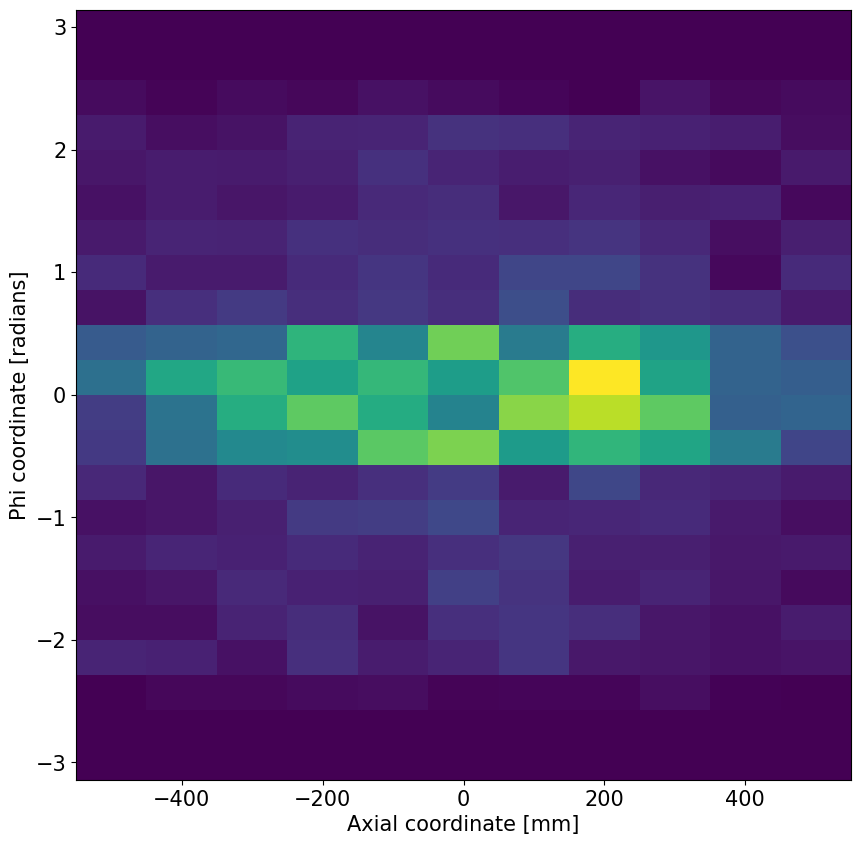

In [8]:
# Longish detector with a short PET phantom in the middle
datasetSize = 1000000
detectorLength = 1100
phantomLength = 100

detectorMaterial = "LSO"
crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", datasetSize, 100.0, 900.0, detectorMaterial )
eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Examine the energy spectrum deposited in the orginal crystal, and in those across the detector

Total hits:  963269


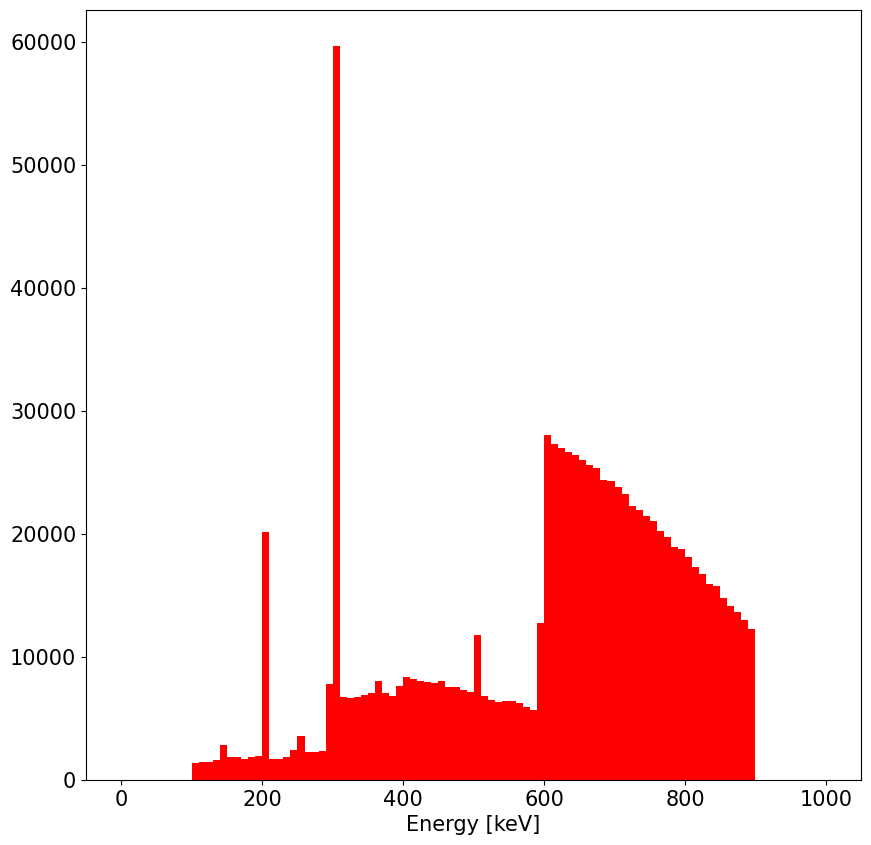

Total hits:  3018


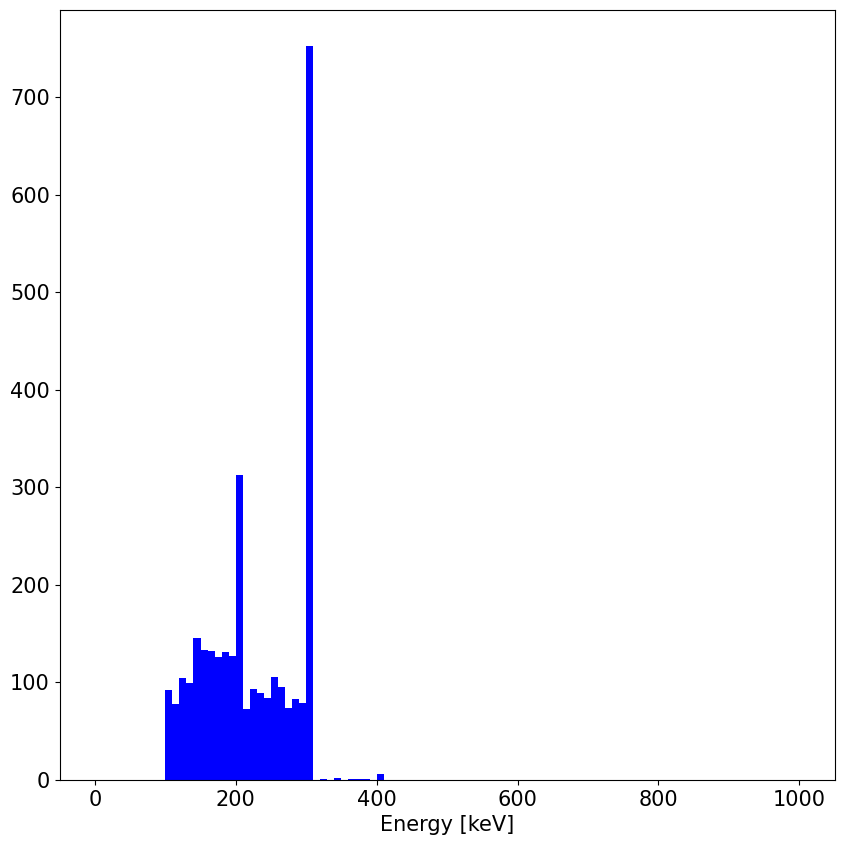

In [9]:
def MakeEnergyHist( energy, colour ):
                
    print( "Total hits: ", len(energy) )
    hist = mpl.hist( energy, bins=100, range=[0,1000], color=colour )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Energy [keV]" )
    mpl.show()

MakeEnergyHist( eNear, "r" )
MakeEnergyHist( eFar, "b" )

Photons that cross the detector do leave a visible attenuation pattern from the phantom. However, the energy captured in the crystal with the original decay is very much larger (from many more hits, with higher energy deposition), so need to specifically identify those events where a photon crossed the detector - can't rely on the simulated setup where one hit is always at phi=0

Try identifying detector-crossing photons using two-hit coincidences (local decay, and emitted photon)

Note that the energy spectrum of the detector-crossing photons is outside the range typically used for a clinical PET scan

In [10]:
import SiemensQuadraProperties as sqp

def ReadBackgroundCoincidences( crystalData, eMin=0.0, eMax=0.0 ):
    
    z = []
    phi = []
    energy = []
    for dataset in crystalData:
        for i in range( dataset.size() ):
            event = dataset.SampleOneEvent()
            
            if TwoHitEvent( event, sqp.DetectorRadius() ):
                for hit in event:
                    eVal = hit[2]
                    
                    if eMin == eMax or ( eVal <= eMax and eVal >= eMin ):
                    
                        phiVal = hit[5]
                        phiVal -= math.pi
                        if phiVal < -math.pi:
                            phiVal += 2.0 * math.pi
                        phi.append( phiVal )

                        z.append( hit[6] )

                        energy.append( eVal )
                    
    return energy, z, phi

def EnergyProfileHistogram( energy, z, phi, ylabel="Deposited energy [keV]" ):
    
    print( "Total hits: ", len(energy) )
    eNear = []
    zNear = []
    eFar = []
    zFar = []
    
    for i, pVal in enumerate(phi):
        eVal = energy[i]
        zVal = z[i]
        
        if math.fabs(pVal) < math.pi/2.0:
            eFar.append(eVal)
            zFar.append(zVal)
        else:
            eNear.append(eVal)
            zNear.append(zVal)
    
    yNear, xNear, dummy = mpl.hist( zNear, bins=22, range=[-550,550], weights=eNear )
    yFar, xFar, dummy = mpl.hist( zFar, bins=22, range=[-550,550], weights=eFar )
    mpl.clf()
    
    xBins = []
    for i, low in enumerate(xNear):
        if i + 1 < len(xNear):
            xBins.append( ( low + xNear[i+1] ) / 2.0 )
    
    mpl.plot( xBins, yNear, color="r", label="Near side" )
    mpl.plot( xBins, yFar, color="b", label="Far side" )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Axial coordinate [mm]" )
    mpl.ylabel( "Total deposited energy [keV]" )
    mpl.legend( ["Near side", "Far side"] )
    mpl.show()
    
def HitProfileHistogram( z, phi ):
    return EnergyProfileHistogram( [1.0]*len(z), z, phi, ylabel="Total hits" )

Counting only hit coincidences, as we would for a PET image, shows a clear attenuation 

Total hits:  3146


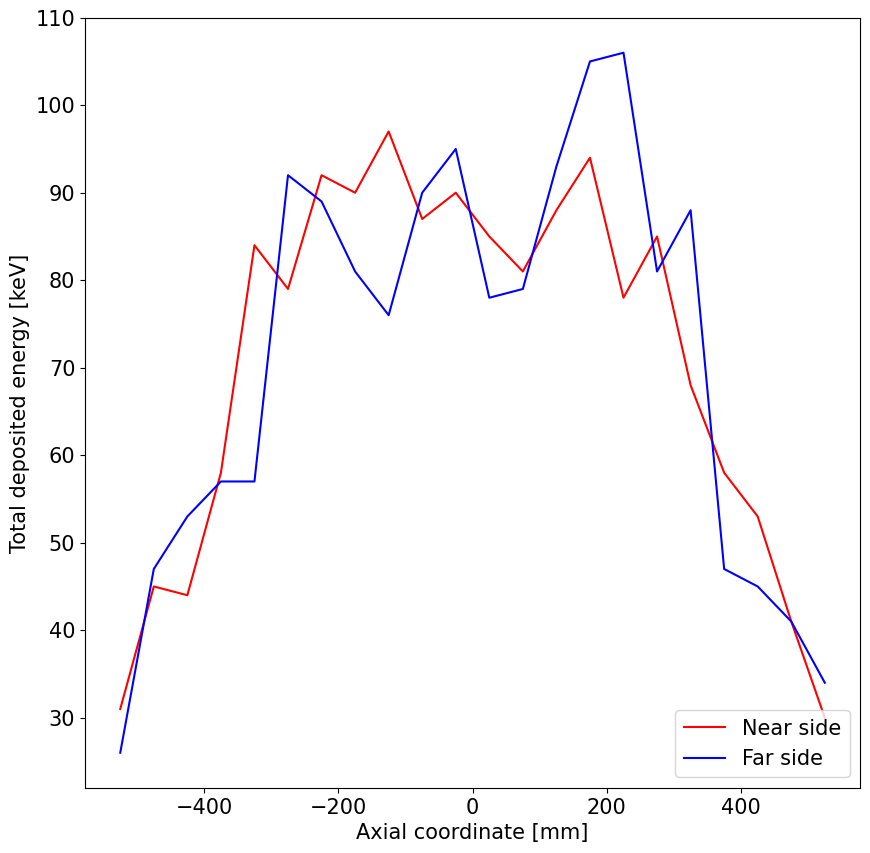

In [11]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Repeating the plot with hits weighted by energy shows the clear difference between near and far side hits, but this is probably a feature of the nuclear decay rather than attenuation in the phantom

Total hits:  3146


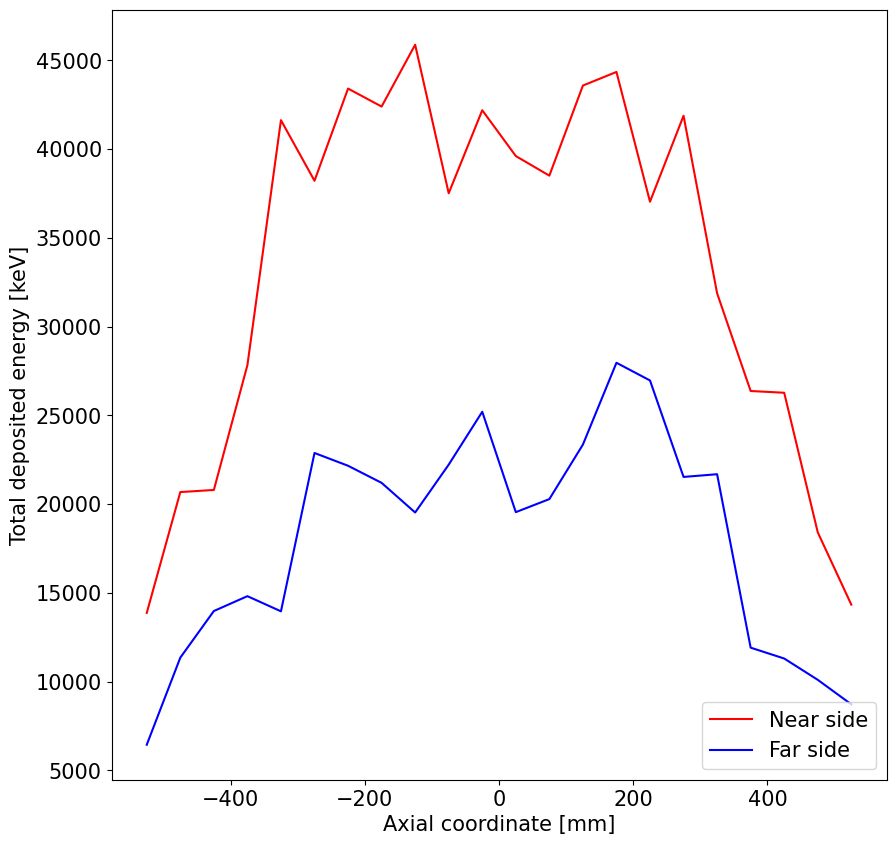

In [12]:
EnergyProfileHistogram( energy, z, phi )

Repeat for different length phantoms


**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: Lu2SiO5
Siemens Quadra detector variant with nRings: 35
Checking overlaps for volume Envelope (G4Tubs) ... OK! 
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : UIMAN0123
      issued by : G4UImanager::ApplyCommand
Command aborted (400)
Error code : 400
*** This is just a warning message.

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

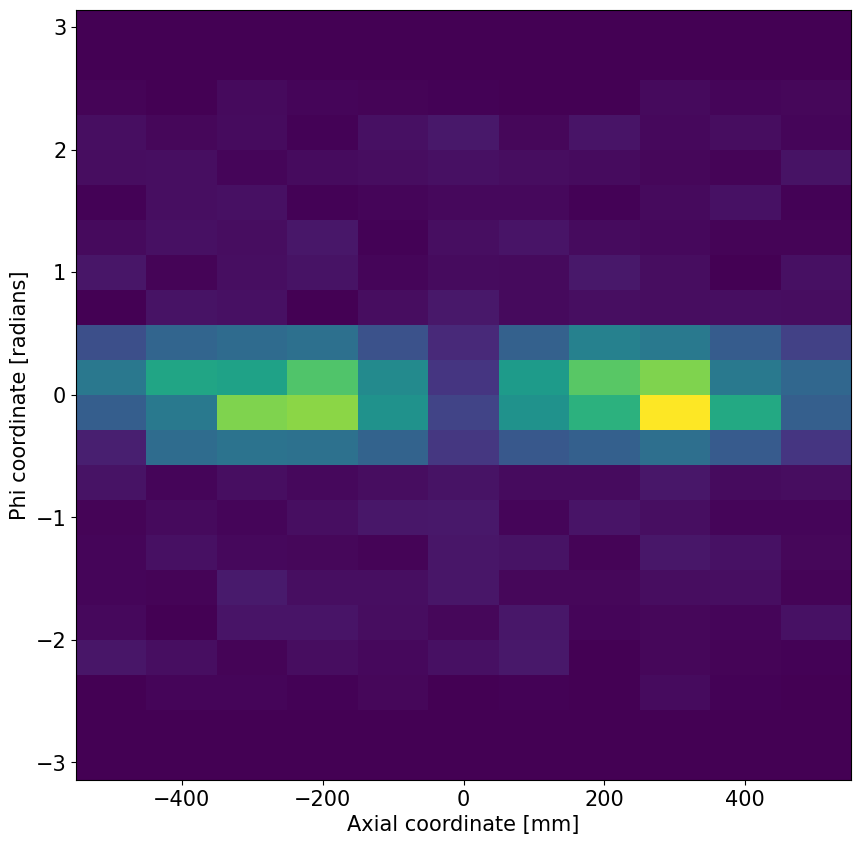

In [14]:
detectorMaterial = "LSO"
crystalData = CreateDataset( detectorLength, "Siemens", 1, "Siemens", datasetSize, 100.0, 900.0, detectorMaterial )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  3066


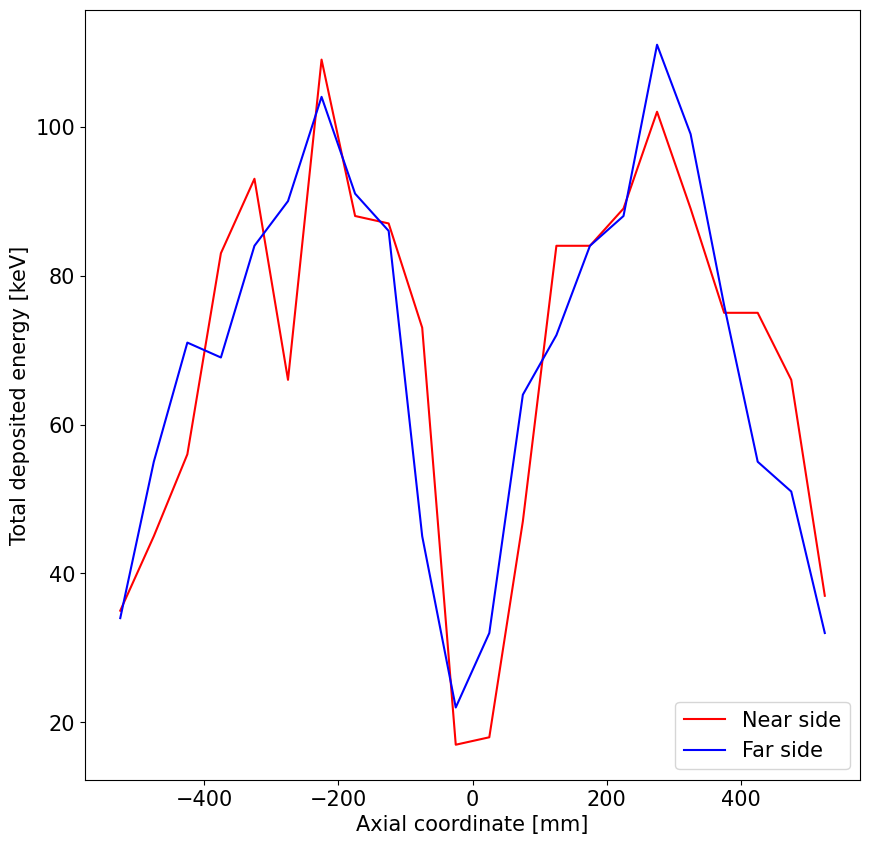

In [15]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  3066


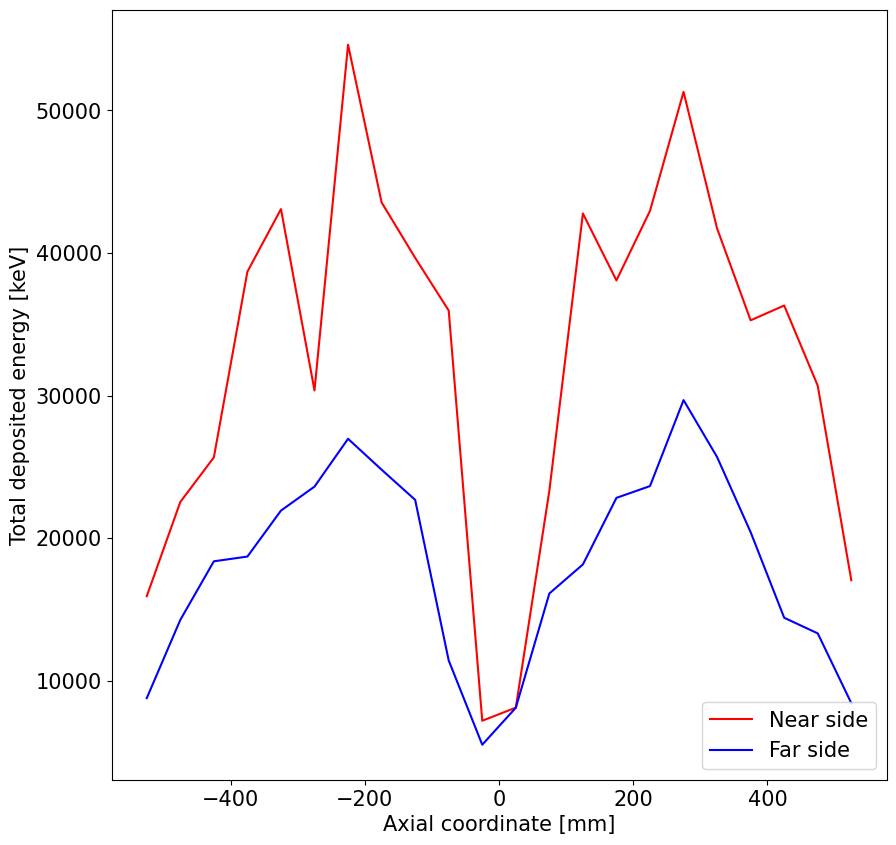

In [16]:
EnergyProfileHistogram( energy, z, phi )


**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: Lu2SiO5
Siemens Quadra detector variant with nRings: 35
Checking overlaps for volume Envelope (G4Tubs) ... OK! 
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : UIMAN0123
      issued by : G4UImanager::ApplyCommand
Command aborted (400)
Error code : 400
*** This is just a warning message.

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

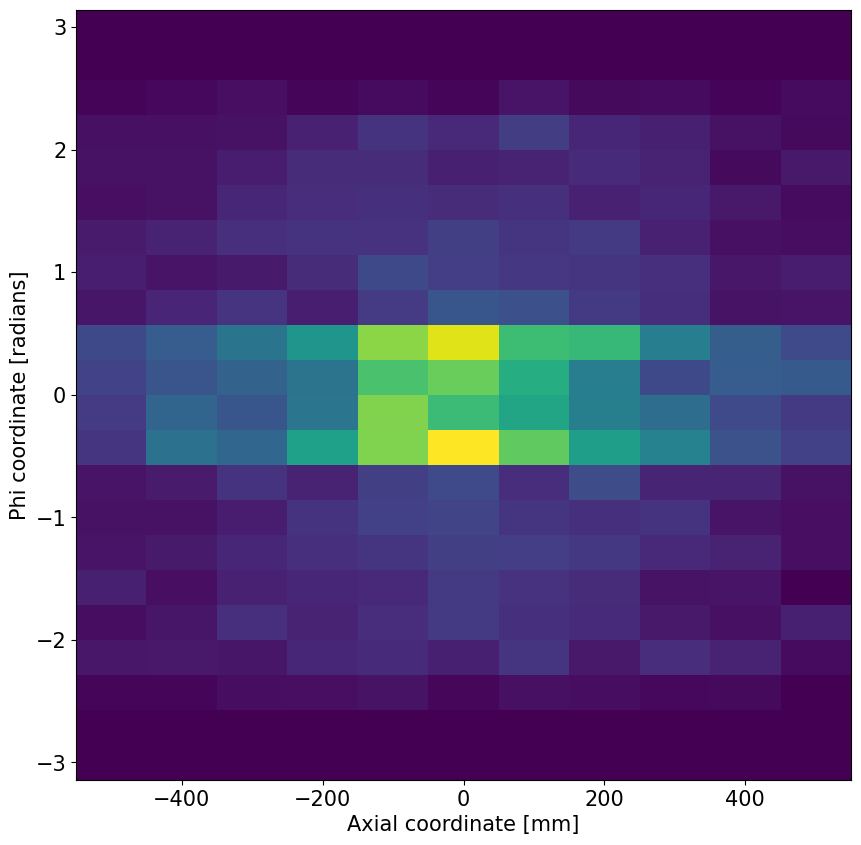

In [17]:
crystalData = CreateDataset( detectorLength, "Siemens", 300, "Siemens", datasetSize, 100.0, 900.0, detectorMaterial )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  4786


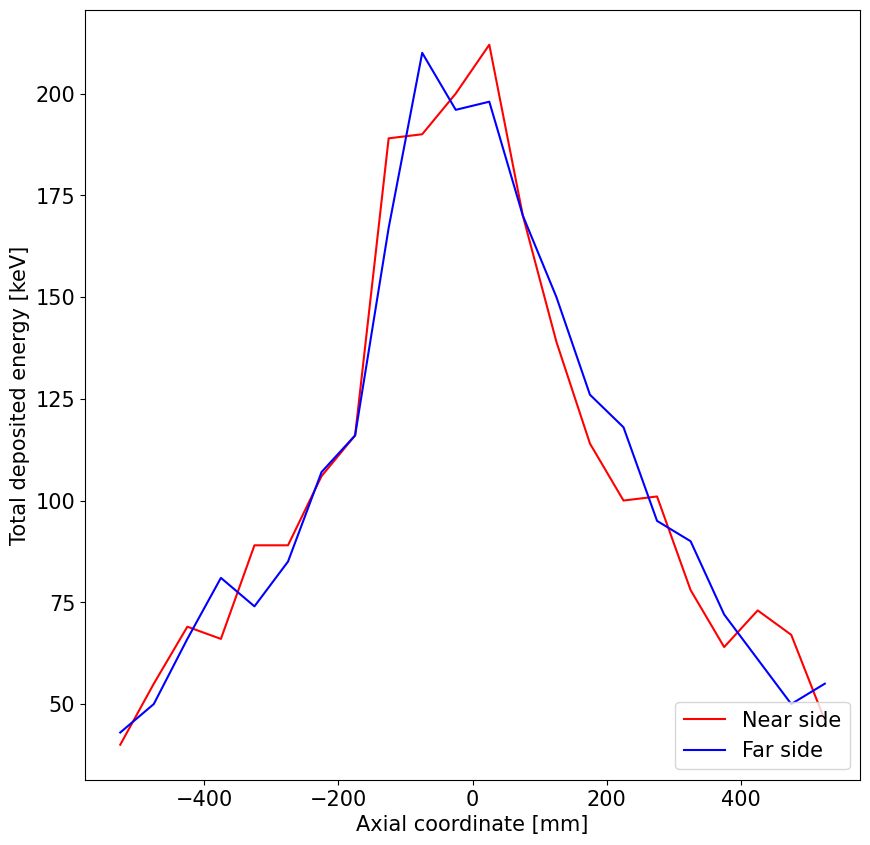

In [18]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  4786


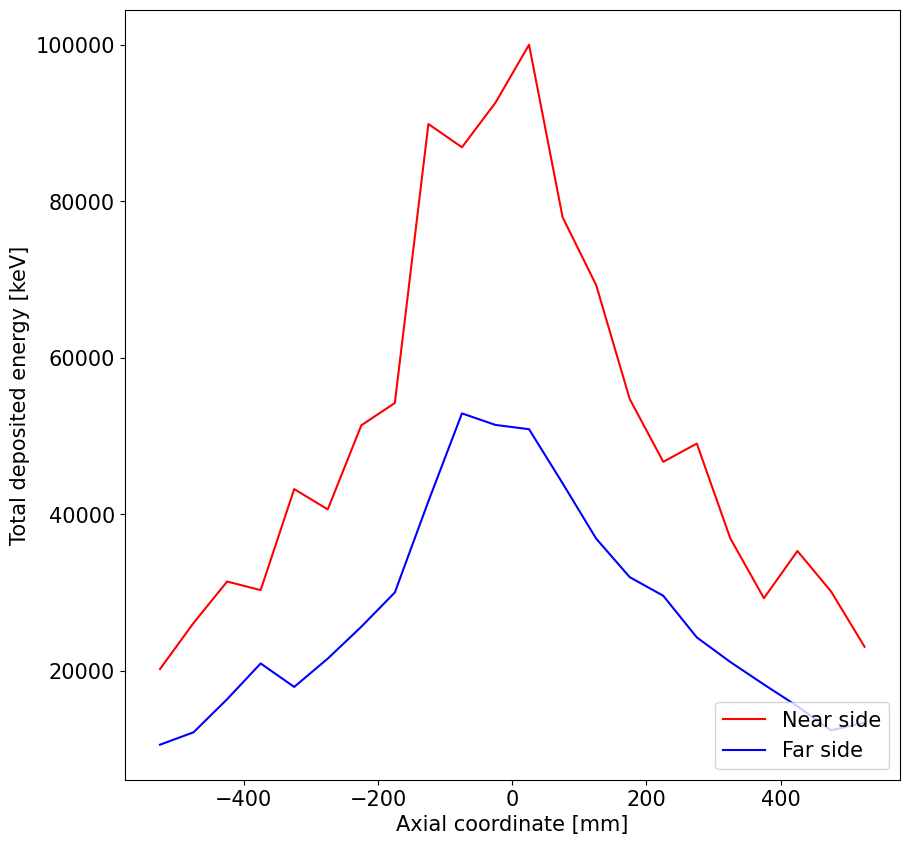

In [19]:
EnergyProfileHistogram( energy, z, phi )


**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Checking overlaps for volume Phantom (G4Tubs) ... OK! 
Selected detector material: Lu2SiO5
Siemens Quadra detector variant with nRings: 35
Checking overlaps for volume Envelope (G4Tubs) ... OK! 
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : UIMAN0123
      issued by : G4UImanager::ApplyCommand
Command aborted (400)
Error code : 400
*** This is just a warning message.

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

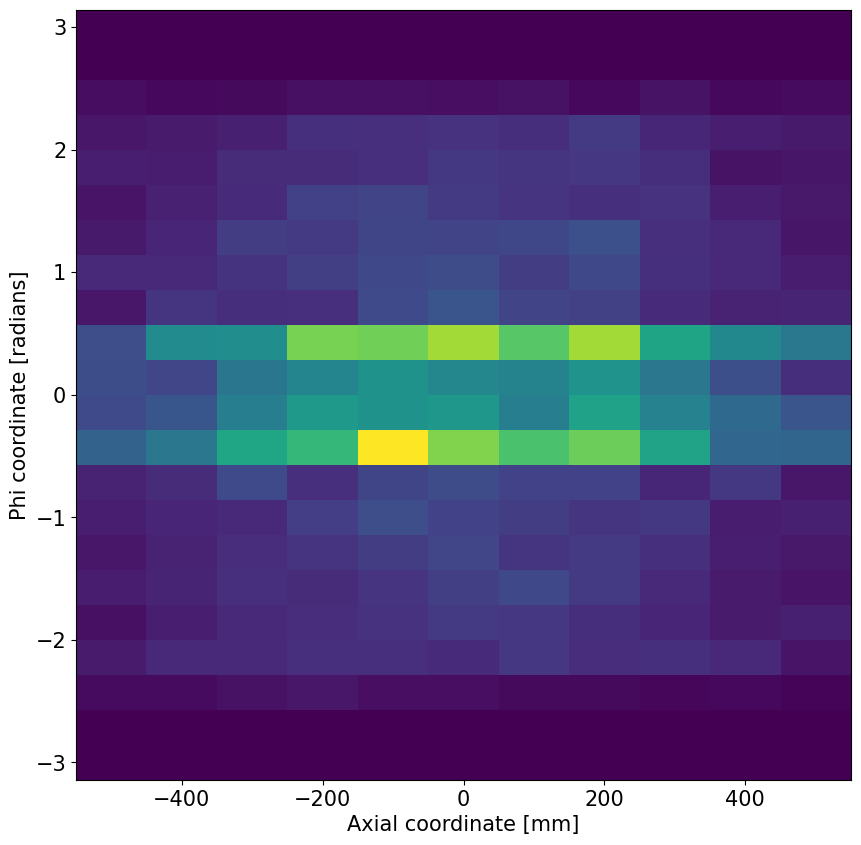

In [20]:
crystalData = CreateDataset( detectorLength, "Siemens", 700, "Siemens", datasetSize, 100.0, 900.0, detectorMaterial )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  7130


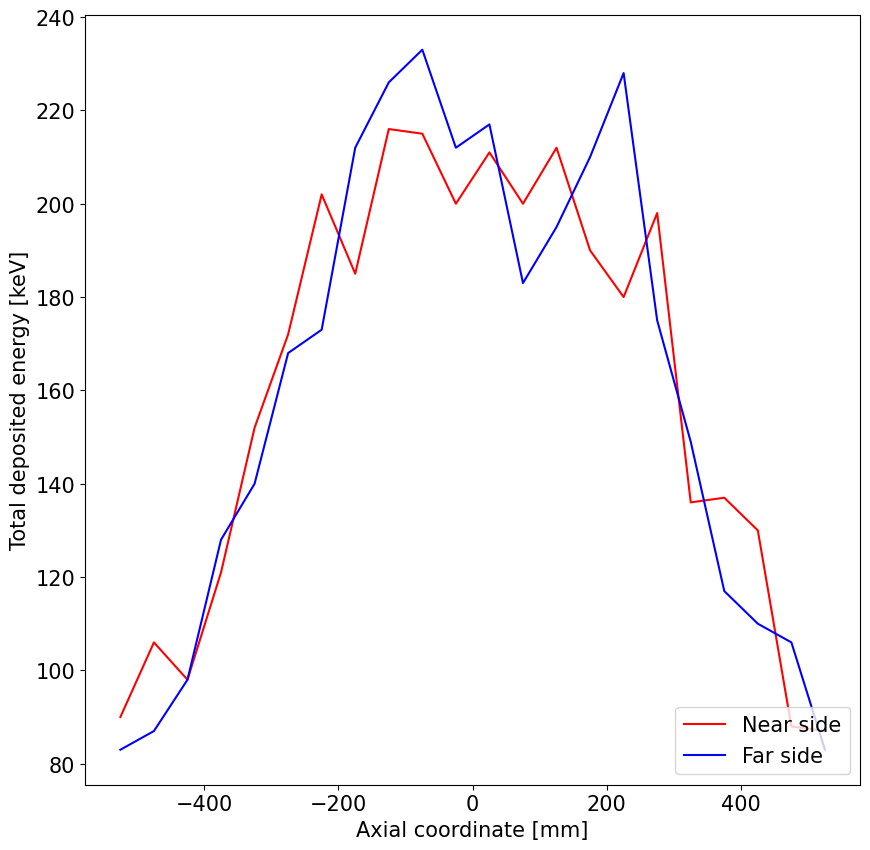

In [21]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  7130


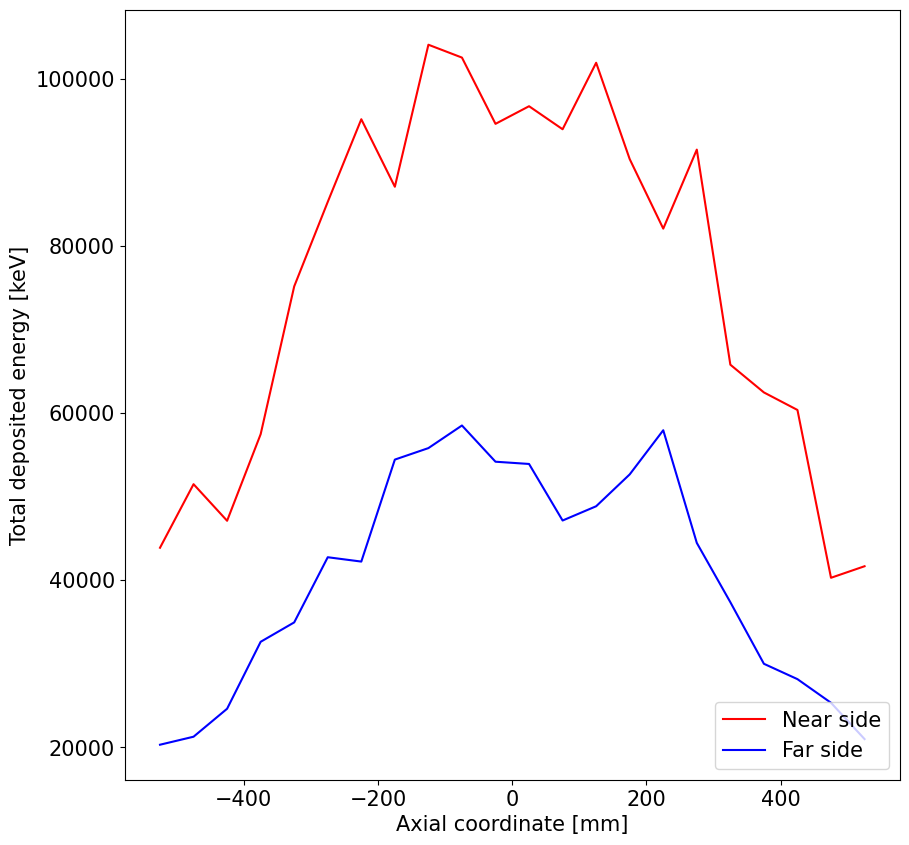

In [22]:
EnergyProfileHistogram( energy, z, phi )


**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Reference Physics List QBBC 
Selected detector material: Lu2SiO5
Siemens Quadra detector variant with nRings: 35
Checking overlaps for volume Envelope (G4Tubs) ... OK! 
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : UIMAN0123
      issued by : G4UImanager::ApplyCommand
Command aborted (400)
Error code : 400
*** This is just a warning message. ***
-------- WWWW -------- G4Exception-END --------- W

ERROR: Can not open a macro file <run.mac>. Set macro path with "/control/macroPath" if needed.



phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag                         1
Store e- internal conversion data                   1
Electron internal conversion 

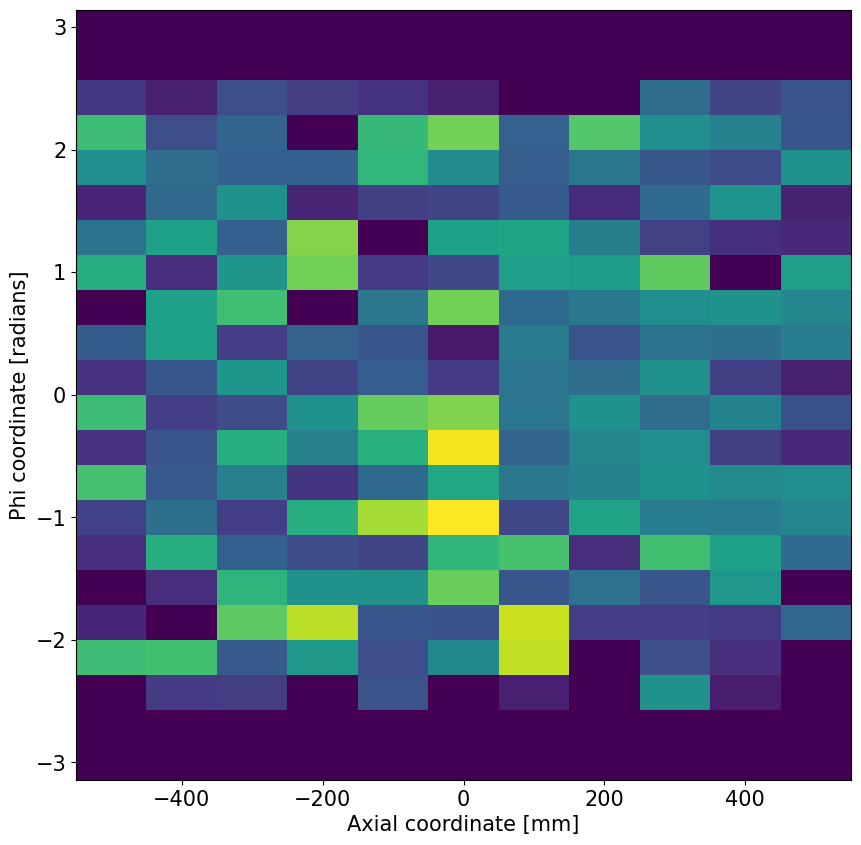

In [24]:
crystalData = CreateDataset( detectorLength, "Siemens", 0, "Siemens", datasetSize, 100.0, 900.0, detectorMaterial )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

In [ ]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

In [ ]:
EnergyProfileHistogram( energy, z, phi )